In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import os, sys, time, pickle, functools
import utils, optimization, metrics, plot, data, evaluation

import plot
from plot import get_animation
import matplotlib.pyplot as plt

from model import WGanModel, LapGanModel
from gan import CosmoGAN
import blocks
from blocks import *

Populating the interactive namespace from numpy and matplotlib


/home/ankit/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fwd = data.fmap.forward
bkd = data.fmap.backward
ln_fwd = data.fmap.log_norm_forward
ln_bkd = data.fmap.log_norm_backward

In [3]:
a = ln_fwd(8001)
print(a)
b = ln_bkd(a)
print(b)

[1.4979078]
[8001.]


In [4]:
dataset = data.load.load_dataset_file(spix=256, resolution=256,Mpch=350, scaling=1, augmentation=False, shuffle=False, forward_map=None, patch=False, is_3d=True)
X = dataset.get_all_data().flatten()

dataset_ln = data.load.load_dataset_file(spix=256, resolution=256,Mpch=350, scaling=1, augmentation=False, shuffle=False, forward_map=ln_fwd, patch=False, is_3d=True)
X_ln = dataset_ln.get_all_data().flatten()
print("log norm check: ", np.sum( np.abs( ln_bkd(X_ln) - X) ) )

dataset_l = data.load.load_dataset_file(spix=256, resolution=256,Mpch=350, scaling=1, augmentation=False, shuffle=False, forward_map=fwd, patch=False, is_3d=True)
X_l = dataset_l.get_all_data().flatten()
print("log check: ", np.sum( np.abs(bkd(X_l) - X) ) )

Loaded all 2 histograms only once in the beginning!
Loaded all 2 histograms only once in the beginning!
log norm check:  0.0
Loaded all 2 histograms only once in the beginning!
log check:  0.0


min value: 0.0
max value: 185874.0


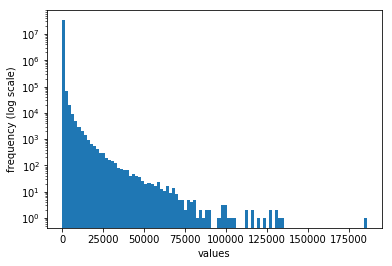

In [9]:
plt.hist(X, 100)
#print("original")
print('min value: {}'.format(np.min(X)))
print('max value: {}'.format(np.max(X)))
plt.xlabel('values')
plt.ylabel('frequency (log scale)')
plt.yscale('log')

min value: 0.0
max value: 5.203132152557373


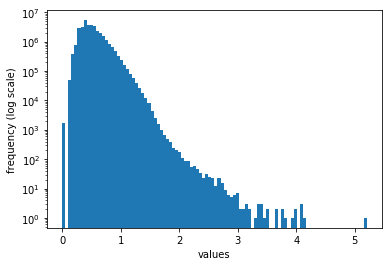

In [11]:
plt.hist(X_ln, 100)
#print("log norm")
print('min value: {}'.format(np.min(X_ln)))
print('max value: {}'.format(np.max(X_ln)))
plt.xlabel('values')
plt.ylabel('frequency (log scale)')
plt.yscale('log')

log
min: 0.0
max: 5.092451095581055


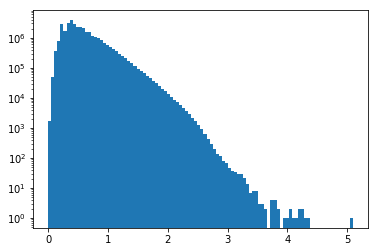

In [10]:
plt.hist(X_l, 100)
print("log")
print('min: {}'.format(np.min(X_l)))
print('max: {}'.format(np.max(X_l)))
plt.yscale('log')

In [12]:
dataset = data.load.load_dataset_file(spix=64, resolution=256,Mpch=350, scaling=4, augmentation=False, shuffle=False, forward_map=None, patch=False, is_3d=True)
X = dataset.get_all_data().flatten()

dataset_ln = data.load.load_dataset_file(spix=64, resolution=256,Mpch=350, scaling=4, augmentation=False, shuffle=False, forward_map=ln_fwd, patch=False, is_3d=True)
X_ln = dataset_ln.get_all_data().flatten()
print("log norm check: ", np.sum( np.abs( ln_bkd(X_ln) - X) ) )

Loaded all 2 histograms only once in the beginning!
Loaded all 2 histograms only once in the beginning!
log norm check:  20368390.0


min value: 2.796875
max value: 17836.234375


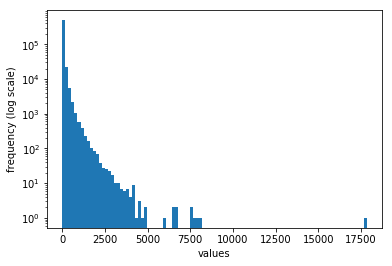

In [13]:
plt.hist(X, 100)
#print("original")
print('min value: {}'.format(np.min(X)))
print('max value: {}'.format(np.max(X)))
plt.xlabel('values')
plt.ylabel('frequency (log scale)')
plt.yscale('log')

min value: 0.20912620425224304
max value: 1.58328378200531


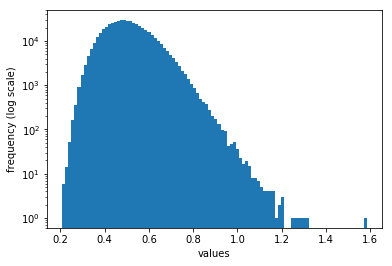

In [14]:
plt.hist(X_ln, 100)
#print("log norm")
print('min value: {}'.format(np.min(X_ln)))
print('max value: {}'.format(np.max(X_ln)))
plt.xlabel('values')
plt.ylabel('frequency (log scale)')
plt.yscale('log')

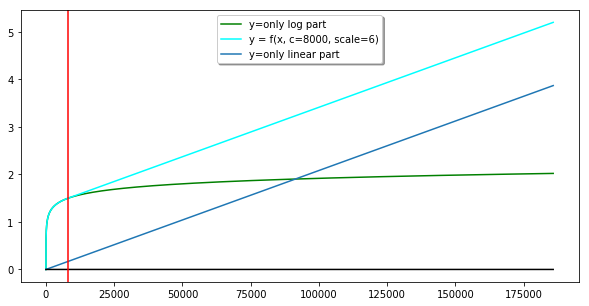

In [35]:
plt.figure(figsize=(10,5))

x = np.arange(0, np.max(X))

y3 = (np.log((x+1)/(8000.0+1)) - np.log((0+1)/(8000.0+1))) / 6.0
plt.plot(y3, label='y=only log part', color='green')

y1 = ln_fwd(x)
plt.plot(y1, label='y = f(x, c=8000, scale=6)', color='cyan')

#y2 = data.fmap.forward(x)
#plt.plot(y2, label='c=log')

y4 = ((x+1)/(8000.0+1) - (0+1)/(8000.0+1) ) / 6.0
plt.plot(y4, label='y=only linear part')

y5 = [0 for i in range(len(x))]
plt.plot(y5, color='black')

plt.axvline(x=8000, color='red')
#plt.xscale('log')

legend = plt.legend(loc='lower corner', shadow=True)

# Gradient Histogram

In [5]:
def calculate_grad(X):
    print('input shape=', X.shape)
    grad_x = np.zeros(X.shape, dtype=np.float32)
    grad_y = np.zeros(X.shape, dtype=np.float32)
    grad_z = np.zeros(X.shape, dtype=np.float32)
    grad = np.zeros(X.shape, dtype=np.float32)

    for i in range(255):
        for j in range(255):
            for k in range(255):
                grad_x[i,j,k] = X[i,j,k+1] - X[i,j,k]
                grad_y[i,j,k] = X[i,j+1,k] - X[i,j,k]
                grad_z[i,j,k] = X[i+1,j,k] - X[i,j,k]

    grad = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)
    
    return grad

input shape= (256, 256, 256)
min: 0.0
max: 248489.890625
********************************Real samples*************************


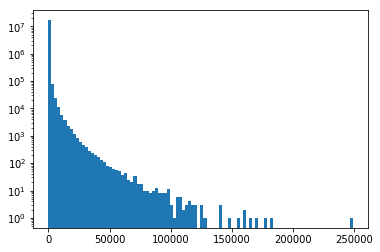

In [10]:
grad = (calculate_grad(dataset.get_all_data()[0, :, :, :]).flatten())
plt.hist(grad, 100)
print('min: {}'.format(np.min(grad)))
print('max: {}'.format(np.max(grad)))

print("********************************Real samples*************************")
plt.yscale('log')

input shape= (256, 256, 256)
min: 0.0
max: 183966.96875
********************************Fake samples - log Transform*************************


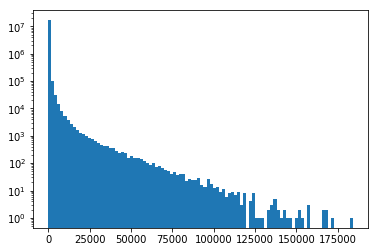

In [11]:
gen_samples_256 = bkd(utils.load_hdf5('Samples/bigstat/0_to_32_to_64_to_256_new_trans/2_256_samples_ckpt_no-inception-298k_98k_119k.h5'))
grad = calculate_grad(gen_samples_256[0,:,:,:]).flatten()
plt.hist(grad, 100)
print('min: {}'.format(np.min(grad)))
print('max: {}'.format(np.max(grad)))

print("********************************Fake samples - log Transform*************************")
plt.yscale('log')

input shape= (256, 256, 256)
min: 0.0
max: 85445.875
********************************Fake samples - log linear Transformation - resnet*************************


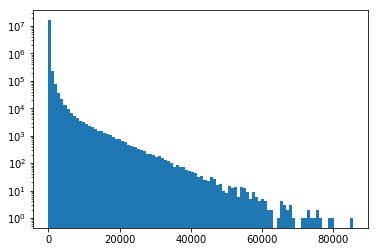

In [12]:
gen_samples_256_raw = ln_bkd(utils.load_hdf5('Samples/final/resnet_64_to_256_log_norm/2_256_samples_ckpt_30k_resnet-22k_60k.h5'))
grad = calculate_grad(gen_samples_256_raw[0, :, :, :]).flatten()
plt.hist(grad, 100)
print('min: {}'.format(np.min(grad)))
print('max: {}'.format(np.max(grad)))

print("********************************Fake samples - log linear Transformation - resnet*************************")
plt.yscale('log')